In [1]:
# Install OpenCV if not installed
!pip install opencv-python matplotlib numpy scikit-image

# Import required libraries
import cv2  # OpenCV for image processing
import numpy as np  # NumPy for numerical operations
import matplotlib.pyplot as plt  # Matplotlib for visualization
from skimage.feature import graycomatrix, graycoprops  # For texture-based feature extraction
from skimage.measure import regionprops, label  # For shape-based feature extraction
from skimage import io, color, filters  # Image processing functions


Saving 3c7b18a8-c266-455c-b552-dd660d9fac50.jpg to 3c7b18a8-c266-455c-b552-dd660d9fac50.jpg


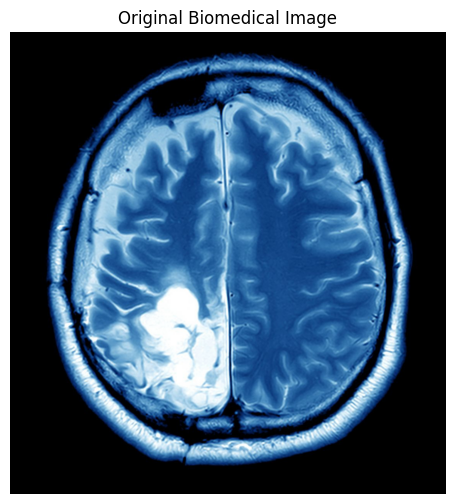

In [2]:
# Upload an image manually in Colab
from google.colab import files
uploaded = files.upload()

# Read the image
image_name = list(uploaded.keys())[0]  # Get the uploaded file name
img = cv2.imread(image_name)

# Convert to grayscale
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Show the original image
plt.figure(figsize=(8, 6)) # Create figure of size 8x6 inches
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original Biomedical Image")
plt.axis("off")
plt.show()


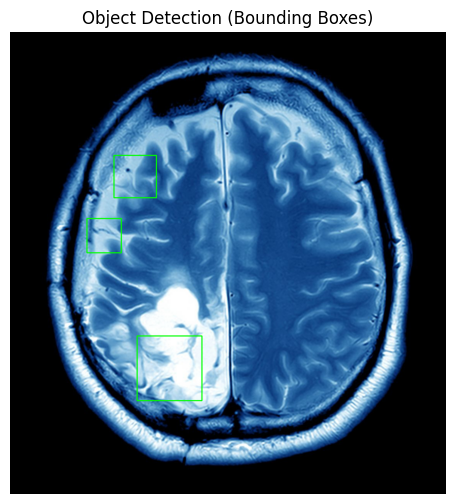

In [3]:
# Load a pre-trained Haar Cascade for object detection (Example: Face, Can be changed for tumors)
haar_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Detect objects (Example: Faces in an X-ray or microscopy image)
objects = haar_cascade.detectMultiScale(gray_img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

# Draw bounding boxes
for (x, y, w, h) in objects:
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Show detected objects
plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Object Detection (Bounding Boxes)")
plt.axis("off")
plt.show()


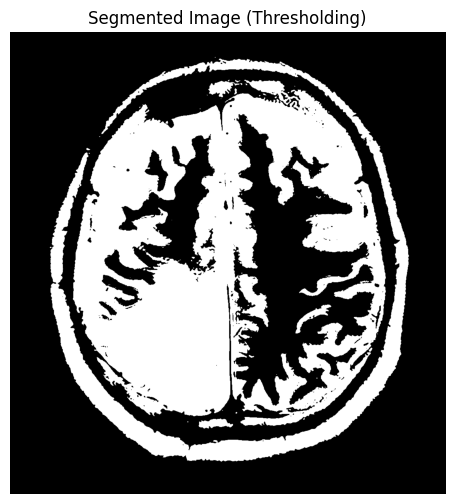

In [4]:
# Apply Otsu's thresholding
_, binary = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Display thresholded image
plt.figure(figsize=(8, 6))
plt.imshow(binary, cmap="gray")
plt.title("Segmented Image (Thresholding)")
plt.axis("off")
plt.show()


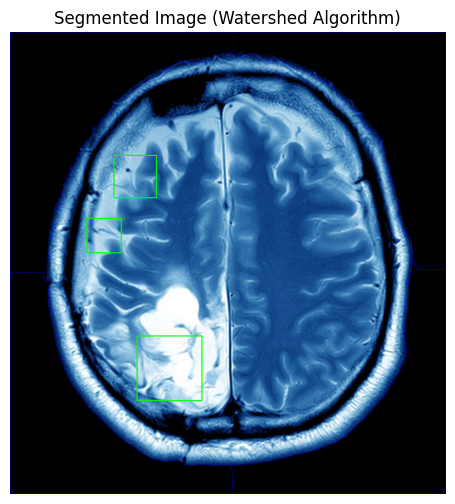

In [5]:
# Convert to binary and find contours
ret, thresh = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# Background area
sure_bg = cv2.dilate(opening, kernel, iterations=3)

# Finding foreground area
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# Label markers
_, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0

# Apply Watershed Algorithm
img_segmented = img.copy()
cv2.watershed(img_segmented, markers)
img_segmented[markers == -1] = [255, 0, 0]  # Mark boundaries in red

# Show segmented image
plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(img_segmented, cv2.COLOR_BGR2RGB))
plt.title("Segmented Image (Watershed Algorithm)")
plt.axis("off")
plt.show()


In [6]:
# Convert image to grayscale (if not already)
gray_img = color.rgb2gray(io.imread(image_name))

# Compute features
features = {}
features["Mean Intensity"] = np.mean(gray_img)
features["Standard Deviation"] = np.std(gray_img)
features["Entropy"] = filters.sobel(gray_img).sum()

# Texture Features using GLCM (Gray-Level Co-occurrence Matrix)
glcm = graycomatrix((gray_img * 255).astype(np.uint8), distances=[1], angles=[0], symmetric=True, normed=True)
features["Contrast"] = graycoprops(glcm, 'contrast')[0, 0]
features["Correlation"] = graycoprops(glcm, 'correlation')[0, 0]
features["Energy"] = graycoprops(glcm, 'energy')[0, 0]
features["Homogeneity"] = graycoprops(glcm, 'homogeneity')[0, 0]

# Display Extracted Features
for key, value in features.items():
    print(f"{key}: {value:.4f}")


Mean Intensity: 0.2643
Standard Deviation: 0.2925
Entropy: 25741.3702
Contrast: 26.4090
Correlation: 0.9976
Energy: 0.3956
Homogeneity: 0.5993
